<a href="https://colab.research.google.com/github/singhbhupender1/Movie-Recommenders/blob/master/Movie_recommendation_using_NeuMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview
In this project, I will use Neural Network Matrix Factorization with Keras to predict the ratings for the movies in [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/)

#[Recommender system](https://en.wikipedia.org/wiki/Recommender_system)

A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

#[Neural Collaborative Filtering](https://dl.acm.org/citation.cfm?id=3052569)

This notebook will present a general framework named NCF, short for Neural network-based Collaborative Filtering. NCF is generic and can express and generalize matrix factorization under its framework. To supercharge NCF modelling with non-linearities, I will leverage a multi-layer perceptron to learn the user-item interaction function. Extensive experiments on real-world datasets show significant improvements of our proposed NCF framework over the state-of-the-art methods. Empirical evidence shows that using deeper layers of neural networks offers better recommendation performance.

#Data Sets
We use [MovieLens Small Datasets](https://grouplens.org/datasets/movielens/latest/) This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org/), a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies. These data were created by 671 users between January 09, 1995 and October 16, 2016. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv

#Project Content
1. Load Data
2. Split Data Into Train/Test
3. Train Generalized Matrix Factorization Model and Test Model
4. Train Multi-Layer Perceptron Model and Test Model
5. Train Neural Matrix Factorization Model (NeuMF) and Test Model
6. Experiment Observations
7. Conclusion and Thoughts

NOTE: Train Neural Matrix Factorization Model (NeuMF) is a stacking version of Generalized Matrix Factorization Model and Multi-Layer Perceptron Model

In [0]:
# a = [] #do not execute it!!!!!!..will crash your system
# while(1):
#     a.append('1')
# #get more ram

First download the data

In [1]:
!wget "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

--2020-03-08 23:17:04--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.24MB/s    in 0.2s    

2020-03-08 23:17:05 (4.24 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [0]:
import shutil
filename = "ml-latest-small.zip"
#archive_format = "zip"

shutil.unpack_archive(filename)

In [0]:
import os

#ML libraries import
import numpy as np
import pandas as pd

#sklearn imports
from sklearn.model_selection import train_test_split

#keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, \
Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

#visualization imports
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
data_path = '/content/ml-latest-small'
ratings_filename = 'ratings.csv'

#1. Load Data

In [0]:
df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols = ['userId', 'movieId', 'rating'],
    dtype = {'userId' : 'int32', 'movieId': 'int32', 'rating' : 'float32'})

In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null int32
movieId    100836 non-null int32
rating     100836 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [9]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [10]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'. \
      format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this dataset


In [13]:
user_maxId = df_ratings.userId.max()
item_maxId = df_ratings.movieId.max()
print('THere are {} distinct users and the max of user ID id also is {}'.format(num_items, item_maxId))
print("In the context of matrix factorizaton, the current item vector is in unnecessarily high dimensional space")
print('so we need to do some data cleaning to reduce the dimensional of item vector back to {}'. format(num_items))

THere are 9724 distinct users and the max of user ID id also is 193609
In the context of matrix factorizaton, the current item vector is in unnecessarily high dimensional space
so we need to do some data cleaning to reduce the dimensional of item vector back to 9724


In [0]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [16]:
print('reduce item dimesion before:')
df_ratings.head()

reduce item dimesion before:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [17]:
df_ratings = reduce_item_dim(df_ratings)
print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,1,0,4.0
1,1,2,4.0
2,1,5,4.0
3,1,43,5.0
4,1,46,5.0


#2. Split Data Into Train/Test

In [19]:
df_train, df_test = train_test_split(df_ratings, test_size = 0.2, shuffle= True, random_state =99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(80668, 3)
shape of test data set:
(20168, 3)



#3. Train Generalized Matrix Factorization and Test Model
###define GMF model architeture and train routine

In [0]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, 'tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model
    

###create GMF model

In [23]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6110        user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        97250       item_input[0][0]                 
______________________________________________________________________________________________

###train GMF model

In [28]:
#model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

#train_model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT,
                      inputs =[df_train.userId.values, df_train.movieId.values],
                      outputs = df_train.rating.values)

Train on 60501 samples, validate on 20167 samples
Epoch 1/30
60501/60501 [==============================] - 4s 62us/sample - loss: 2.5807 - mean_squared_error: 2.5807 - rmse: 1.5776 - val_loss: 1.6081 - val_mean_squared_error: 1.6081 - val_rmse: 1.2640
Epoch 2/30
60501/60501 [==============================] - 4s 63us/sample - loss: 1.1438 - mean_squared_error: 1.1438 - rmse: 1.0640 - val_loss: 1.0914 - val_mean_squared_error: 1.0914 - val_rmse: 1.0385
Epoch 3/30
60501/60501 [==============================] - 4s 64us/sample - loss: 0.8346 - mean_squared_error: 0.8346 - rmse: 0.9084 - val_loss: 0.9552 - val_mean_squared_error: 0.9552 - val_rmse: 0.9728
Epoch 4/30
60501/60501 [==============================] - 4s 63us/sample - loss: 0.7166 - mean_squared_error: 0.7166 - rmse: 0.8421 - val_loss: 0.9126 - val_mean_squared_error: 0.9126 - val_rmse: 0.9507
Epoch 5/30
60501/60501 [==============================] - 4s 60us/sample - loss: 0.6514 - mean_squared_error: 0.6514 - rmse: 0.8025 - val_

###GMF learning curve

In [0]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

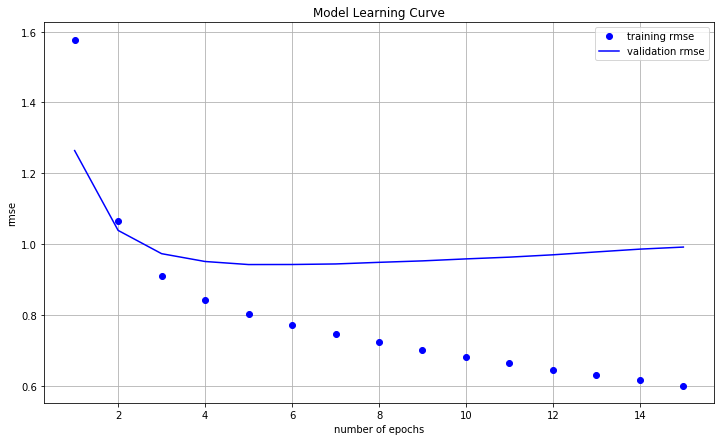

In [31]:
plot_learning_curve(history, 'rmse')


###GMF model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [0]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

In [33]:
# load best model
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = GMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9462


#4. Train Multi-Layer Perceptron Model and Test Model
###define MLP model architeture

In [0]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

###create MLP model

In [35]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        311200      item_input[0][0]                 
____________________________________________________________________________________________

###train MLP model

In [36]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 60501 samples, validate on 20167 samples
Epoch 1/30
60501/60501 [==============================] - 5s 78us/sample - loss: 1.6983 - mean_squared_error: 1.6983 - rmse: 1.1260 - val_loss: 0.7861 - val_mean_squared_error: 0.7861 - val_rmse: 0.8817
Epoch 2/30
60501/60501 [==============================] - 4s 73us/sample - loss: 0.7233 - mean_squared_error: 0.7233 - rmse: 0.8458 - val_loss: 0.7665 - val_mean_squared_error: 0.7665 - val_rmse: 0.8705
Epoch 3/30
60501/60501 [==============================] - 4s 73us/sample - loss: 0.6756 - mean_squared_error: 0.6756 - rmse: 0.8169 - val_loss: 0.7571 - val_mean_squared_error: 0.7571 - val_rmse: 0.8638
Epoch 4/30
60501/60501 [==============================] - 4s 73us/sample - loss: 0.6426 - mean_squared_error: 0.6426 - rmse: 0.7966 - val_loss: 0.7573 - val_mean_squared_error: 0.7573 - val_rmse: 0.8639
Epoch 5/30
60501/60501 [==============================] - 4s 73us/sample - loss: 0.6098 - mean_squared_error: 0.6098 - rmse: 0.7760 - val_

###MLP learning curve

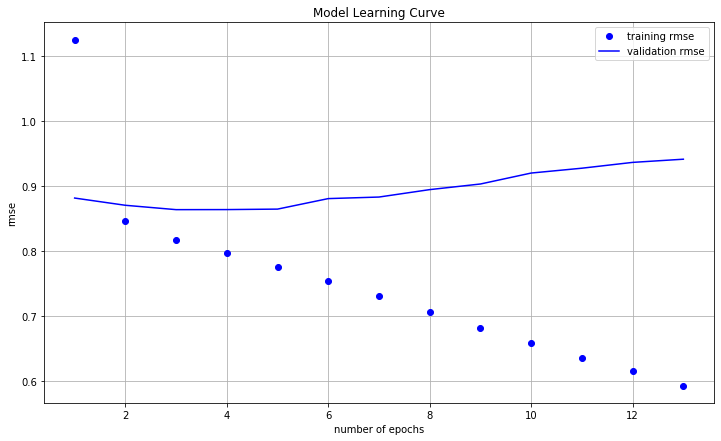

In [37]:
plot_learning_curve(history, 'rmse')


###MLP model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [38]:
# load best model
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = MLP_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8709


#5. Train Neural Matrix Factorization (NeuMF) and Test Model
###define NeuMF model architeture

In [0]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

###create NeuMF model

In [40]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        311200      item_input[0][0]                 
____________________________________________________________________________________________

###train NeuMF model


In [41]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 60501 samples, validate on 20167 samples
Epoch 1/30
60501/60501 [==============================] - 6s 95us/sample - loss: 1.6470 - mean_squared_error: 1.6470 - rmse: 1.1139 - val_loss: 0.7875 - val_mean_squared_error: 0.7875 - val_rmse: 0.8828
Epoch 2/30
60501/60501 [==============================] - 5s 87us/sample - loss: 0.7126 - mean_squared_error: 0.7126 - rmse: 0.8389 - val_loss: 0.7667 - val_mean_squared_error: 0.7667 - val_rmse: 0.8708
Epoch 3/30
60501/60501 [==============================] - 5s 86us/sample - loss: 0.5832 - mean_squared_error: 0.5832 - rmse: 0.7589 - val_loss: 0.7814 - val_mean_squared_error: 0.7814 - val_rmse: 0.8787
Epoch 4/30
60501/60501 [==============================] - 5s 87us/sample - loss: 0.4508 - mean_squared_error: 0.4507 - rmse: 0.6671 - val_loss: 0.8269 - val_mean_squared_error: 0.8269 - val_rmse: 0.9029
Epoch 5/30
60501/60501 [==============================] - 5s 87us/sample - loss: 0.3724 - mean_squared_error: 0.3724 - rmse: 0.6057 - val_

###Neural Matrix Factorization (NeuMF) learning curve

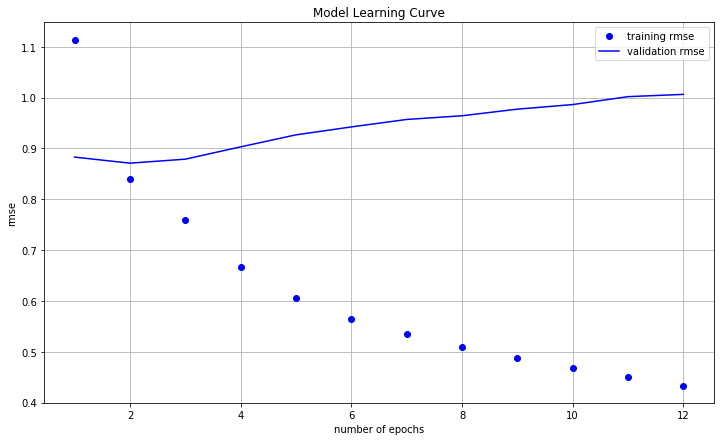

In [42]:
plot_learning_curve(history, 'rmse')

###Neural Matrix Factorization (NeuMF) model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [43]:
# load best model
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = NeuMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8731


#Observations
1. ALS's out-of-sample RMSE is 0.8154
2. GMF's out-of-sample RMSE is 0.9462
3. MLP's out-of-sample RMSE is 0.8709
4. NeuMF's out-of-sample RMSE is 0.8731
5. Rating prediction out-of-sample performance in terms of RMSE (the lower the better): ALS < MLP < NeuMF < GMF
6. The best model is ALS


#Conclusion
1. Deep neural networks can achieve a better performance in recommendation system, specifically at Collaborative Filtering
2. As you increase the depth of the network or broaden the network branches, the performance of the model also increases